In [50]:
from starry.kepler import Primary, Secondary, System
import numpy as np
import slepian
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math
np.random.seed(264)

In [51]:
def changeOfBasis(L):
    """Change of basis matrix."""
    
    return np.array(slepian.slepianToHarmonic(L),dtype=float)

In [52]:
def setCoeffs(X,d,planet):
    """Takes a harmonic vector X and sets the starry map parameters."""
    
    # Pull out the Y0,0 coefficient X0 to set L
    X0 = X[0] 
    
    # Renormalize so that X0 = 1
    X = X/X0 
    
    # Set luminosity
    planet.L = d*X0 
    
    # Set map coefficients
    planet[1,:] = X[1:] 
    
    return

In [53]:
def getLightCurve(X,par):
    """Creates a planet-star system and generate the planet light curve."""
    
    d,time,system,planet,L,C = par

    # Set map coefficients
    setCoeffs(X,d,planet)
    
    # Compute the flux
    system.compute(time)
    flux = planet.lightcurve
    
    return flux

In [54]:
def lnPrior(X):
    """Log prior probability."""
    
    # Map coefficents should be |X| < 1 and 
    # X0 > 0 so that luminosity is positive. 
    if np.any(np.abs(X) > 1) or (X[0] <= 0): 
        return -np.inf
    else:
        return 0

In [55]:
def lnLike(var,par,flux):
    """Log likelihood."""
    
    # Seperate arguments
    d,time,system,planet,L,C = par
    T = var[:(L+1)**2]
    flux_err = var[(L+1)**2]
    
    # Convert from slepian to harmonic vector.
    X = np.dot(C,T) 
    
    # Check that X fits the priors.
    l = lnPrior(X)
    if np.isinf(l):
        return l
    
    # Create a system and get the computed flux.
    c_flux = getLightCurve(X,par)
    
    # Caluculate log likelihood.
    like = np.sum(((flux - c_flux)/flux_err)**2 + np.log(flux_err**2))
    l += -0.5*like
    
    return l

In [56]:
def maxLike(lnLike,var_guess,par,flux):
    """Maximum likelihood solution for slepian coefficients."""
    
    # Define negative log likelihood
    nlnLike = lambda *args: -lnLike(*args)

    # Find the numerical optimum of the likelihood function
    soln = minimize(nlnLike, var_guess, args = (par,flux),method='Nelder-Mead')
    var_msol = soln.x

    return var_msol

In [57]:
"""Initial Settings"""
# Time
time = np.linspace(0.73, 0.88, 1000)

# Bandlimit
L = 1
C = changeOfBasis(L)

# Instantiate star-planet system
star = Primary()
planet = Secondary(L)
system = System(star, planet)

d = 0.001 # eclipse depth
planet.r = 0.1504
planet.a = 8.73 # Orbital semi-major axis in units of the stellar radii.
planet.inc = 85.690 # Orbital inclination (90 degrees is an edge-on orbit)
planet.porb = 2.21857 # Orbital period in Julian days
planet.prot = 2.21857 # Rotation period in days (synchronous if prot=porb)
planet.ecc = 0 # Eccentricity
#planet.w = 90  # Longitude of pericenter in degrees (meaningless for ecc=0)
planet.tref = 2458334.990899 # Time of transit in Julian days


par = d,time,system,planet,L,C

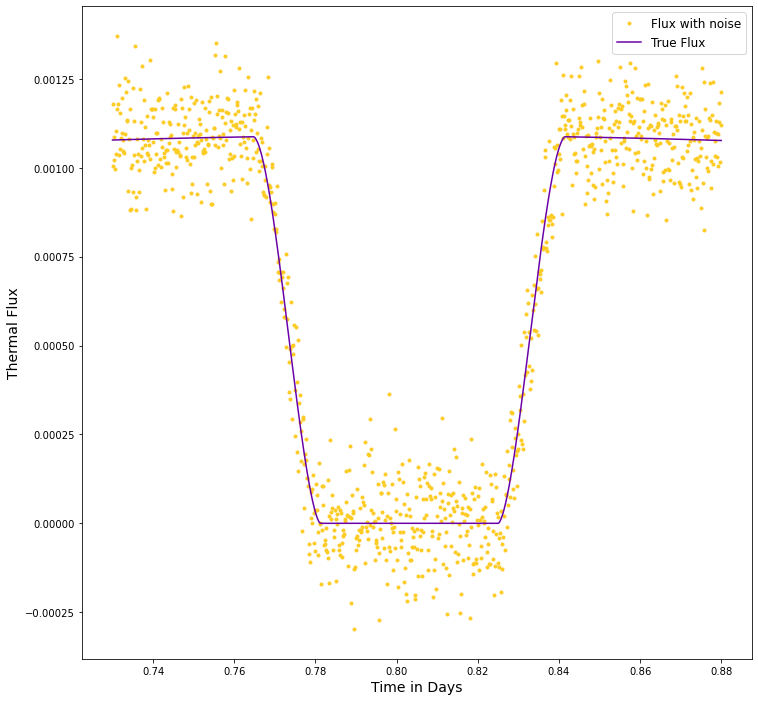

In [58]:
"""Create synthetic data."""

#Define the true variables
var_true = np.array([0.7,0.3,0.0,0.0,d/10])#1/3, 1/5, 1/10 or eclipse depth
T_true = var_true[:(L+1)**2]
X_true = np.dot(C,T_true)

# Generate the light curve for true planet
flux_true = getLightCurve(X_true,par)

# Add noise
flux = flux_true + var_true[(L+1)**2]*np.random.randn(1000)

# Print and plot
plt.figure(figsize=(12,12))
plt.plot(time,flux, color = '#FCCC25',marker = '.',linestyle ='None',label = 'Flux with noise')
plt.plot(time,flux_true, color = '#6A00A7', marker = 'None', label = 'True Flux')
plt.legend(fontsize=12)
plt.xlabel("Time in Days",fontsize=14)
plt.ylabel("Thermal Flux",fontsize=14)
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

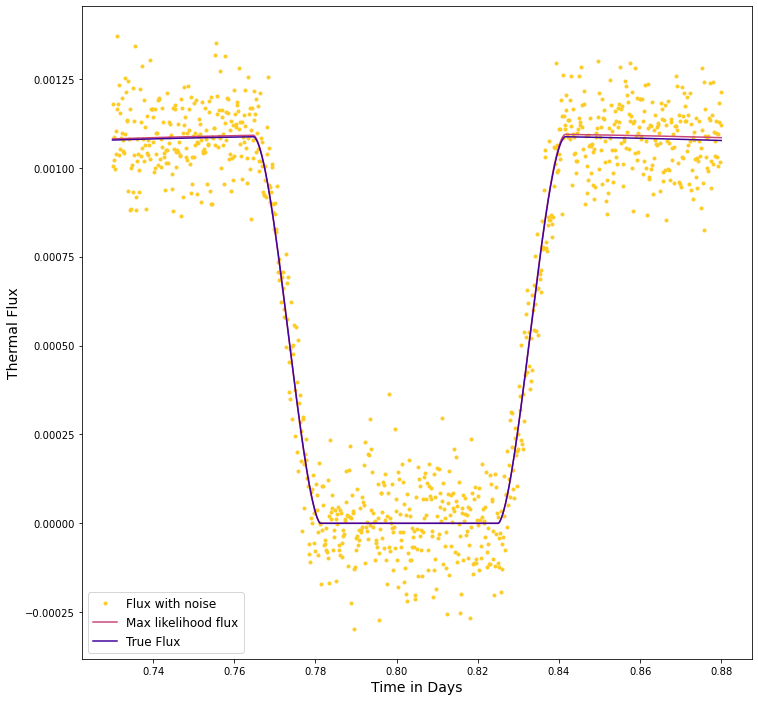

In [59]:
"""Find the max likelihood solution."""

# Define a guess
var_guess = np.array([0.1,0.1,0,0,0.1])

# Find the max likelihood variables
var_msol = maxLike(lnLike,var_guess,par,flux)

# Print and plot max likelihood results
T_msol = var_msol[:(L+1)**2]

labels = ["T_1","T_2","T_3","T_4","\sigma"]
for i in range(len(var_msol)):
    txt = "\mathrm{{{1}}} = {0:.4f}"
    txt = txt.format(var_msol[i], labels[i])
    display(Math(txt))
    
X_msol = np.dot(C,T_msol)
flux_msol = getLightCurve(X_msol,par)

plt.figure(figsize=(12,12))
plt.plot(time,flux, color = '#FCCC25',marker = '.',linestyle ='None',label = 'Flux with noise')
plt.plot(time,flux_msol, color = '#CA4678', marker = 'None', label = 'Max likelihood flux')
plt.plot(time,flux_true, color = '#40039C', marker = 'None', label = 'True Flux')
plt.legend(fontsize=12)
plt.xlabel("Time in Days",fontsize=14)
plt.ylabel("Thermal Flux",fontsize=14)
plt.show()

In [60]:
"""Run an MCMC chain"""

# Initialize around the max likelihood solution
var_init = var_msol + var_msol*1e-4*np.random.randn(32,len(var_msol)) #32 random walkers 
nwalkers,ndim = var_init.shape

nsteps = 5000

# Run an MCMC chain
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnLike, args = (par,flux))
sampler.run_mcmc(var_init, nsteps, progress=True)                                

100%|██████████| 5000/5000 [02:39<00:00, 31.35it/s]


State([[ 6.86255140e-01  2.22668901e-01  1.41126633e-02 -2.87620518e-01
   9.87691206e-05]
 [ 7.10040988e-01  2.49914011e-01  9.07626467e-03  3.45825987e-02
   9.81751913e-05]
 [ 6.58713171e-01  4.22713221e-01  1.78596101e-02 -6.17828388e-01
   1.00535087e-04]
 [ 6.70264942e-01  4.35038703e-01 -2.28746428e-02 -4.12344003e-01
   9.82316223e-05]
 [ 6.97305248e-01  3.12895757e-01  2.90364872e-02 -2.97798962e-02
   1.01605544e-04]
 [ 6.90031338e-01  3.79296461e-01  4.21379245e-02 -1.44142130e-01
   1.02876541e-04]
 [ 7.03697124e-01  3.31388436e-01  1.24029640e-02  5.62516114e-02
   9.97532397e-05]
 [ 7.03987534e-01  2.96611922e-01  4.05712122e-02 -1.04774997e-02
   9.90556622e-05]
 [ 6.72566115e-01  3.11852657e-01 -4.46814369e-03 -4.57909669e-01
   9.89601245e-05]
 [ 6.78661148e-01  3.56898938e-01  1.80572485e-02 -3.21738339e-01
   9.77021513e-05]
 [ 7.06947209e-01  2.26514827e-01  2.66127584e-02 -2.42332580e-02
   9.91342176e-05]
 [ 7.25917653e-01  1.90630935e-01  1.35375455e-02  1.870402

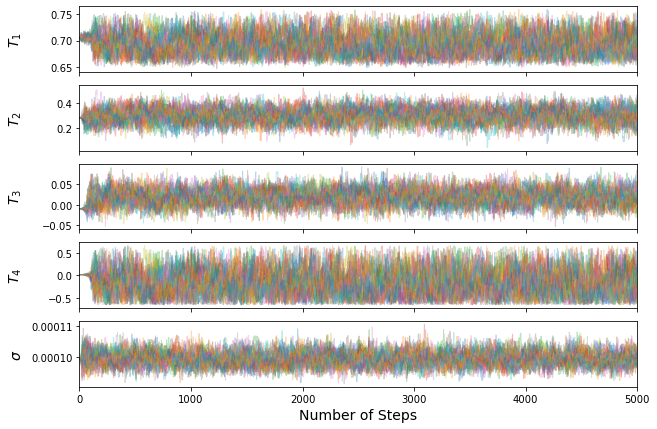

In [61]:
"""Plot the chains"""

fig, axes = plt.subplots(len(var_msol), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labelsp = [r"$T_1$", r"$T_2$", r"$T_3$",r"$T_4$",r"$\sigma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3,lw = 1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labelsp[i],fontsize=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Number of Steps",fontsize=14);

In [62]:
"""Burn in."""

# An estimate of the integrated autocorrelation time
tau = sampler.get_autocorr_time()
print(tau)

#Set the burn-in
nburn = 400

[70.71661762 64.41770309 61.20170885 71.7623066  62.92411591]


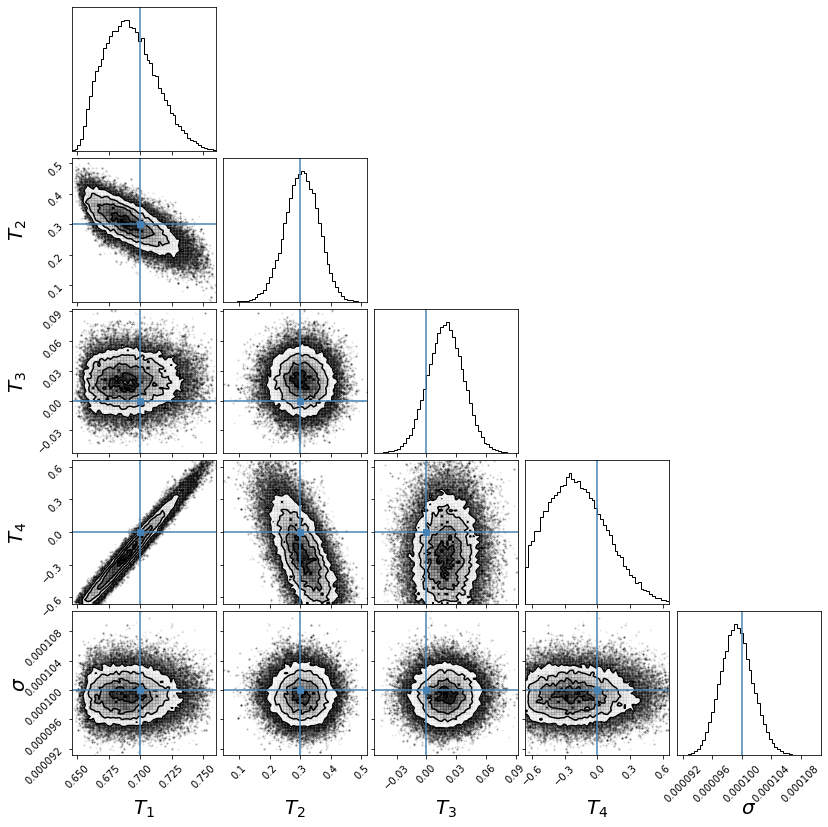

In [63]:
"""Corner plot"""

# Plot the corner plot
samples = sampler.chain[:, nburn:, :].reshape(nwalkers * (nsteps-nburn), ndim)
fig = corner.corner(samples, labels=labelsp, bins=50, truths = var_true);
for ax in fig.axes:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

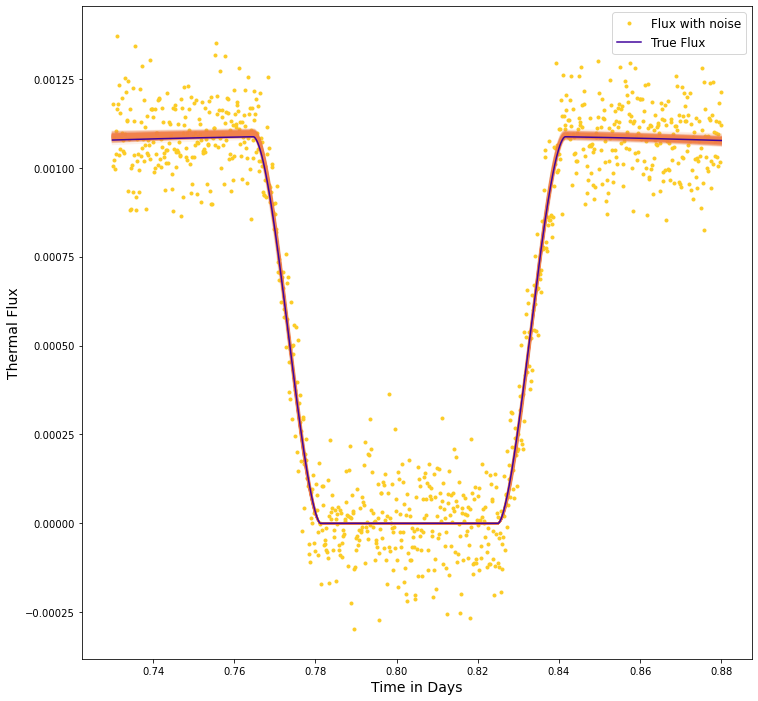

In [64]:
"""Sample Solutions"""

flat_samples = sampler.get_chain(discard=100, thin=30, flat=True)

plt.figure(figsize=(12,12))
plt.plot(time,flux, color = '#FCCC25',marker = '.',linestyle ='None',label = 'Flux with noise')
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = getLightCurve(np.dot(C,flat_samples[ind][:(L+1)**2]),par)
    plt.plot(time, sample, color = "#F1824C", alpha=0.1)
plt.plot(time, flux_true, color = '#40039C', marker = 'None', label = 'True Flux')
plt.legend(fontsize=12)
plt.xlabel("Time in Days",fontsize=14)
plt.ylabel("Thermal Flux",fontsize=14)
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

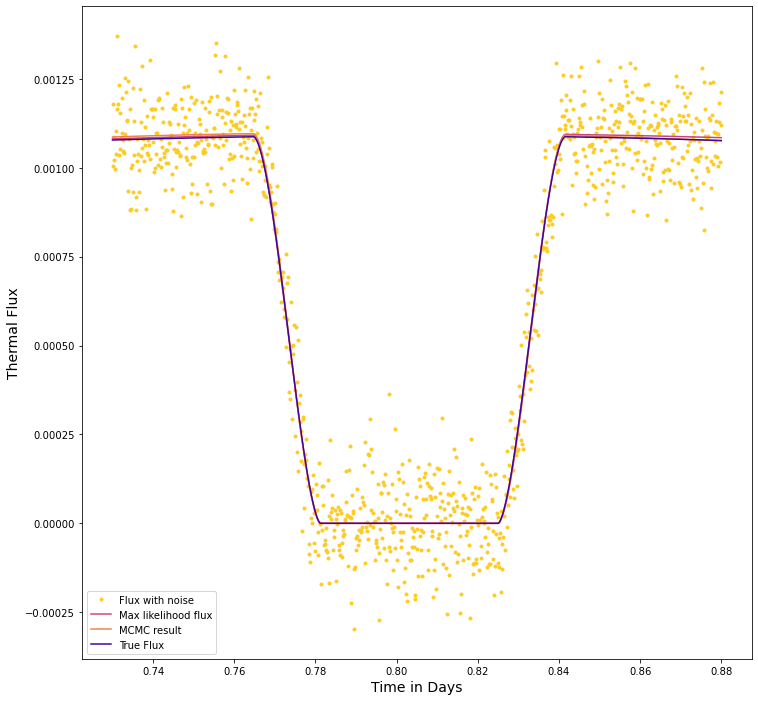

In [65]:
"""MCMC Solution."""

var_mcmc = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    var_mcmc.append(mcmc[1])
    
    
X_r = np.dot(C,var_mcmc[:(L+1)**2])
flux_r = getLightCurve(X_r,par)

plt.figure(figsize=(12,12))
plt.plot(time,flux, color = '#FCCC25',marker = '.',linestyle ='None',label = 'Flux with noise')
plt.plot(time,flux_msol, color = '#CA4678', marker = 'None', label = 'Max likelihood flux')
plt.plot(time,flux_r, color = '#F1824C', marker = 'None', label = 'MCMC result')
plt.plot(time, flux_true, color = '#40039C', marker = 'None', label = 'True Flux')
plt.legend(fontsize=10)
plt.xlabel("Time in Days",fontsize=14)
plt.ylabel("Thermal Flux",fontsize=14)
plt.show()